In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import os
import math
%matplotlib inline

In [2]:
path = os.getcwd()
labels_df = pd.read_csv(path + '/labels.csv')
labels = np.array(labels_df[' hemorrhage'].tolist())

files = sorted(glob.glob(path + '/head_ct/*.png'))
images = [cv2.imread(path) for path in files]

# Eksplorativna analiza

Dataset se sastoji od 100 slika sa krvarenjem i 100 normalnih slika. 
Slike nisu iste velicine, tako da je potrebno da se pronadje optimalna velicina slika da se ne izgube detalji. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018E0A113B38>,
      dtype=object)

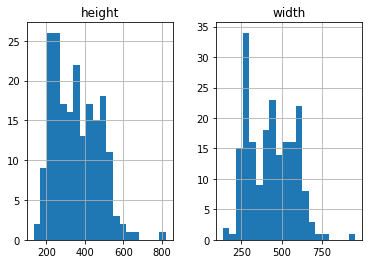

In [3]:
images_df = pd.DataFrame(images, columns=['image'])
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])
images_df[['height', 'width']].hist(bins=20)

In [4]:
images_df[['height', 'width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


Na gore prikazanam histogramu se moze uociti da velicina slika dosta varira. Jedan nacin je da se sve slike svedu na velicinu najmanje slike (128x128). Na ovaj nacin bi se povecala kompjuterska efikasnost, jer bi model obradjivao manji broj piksela. 
Drugi pristup je da se koristi najcesca velicina slika, gde bi manje slike bivale prosirene, a vece umanjene kao u prethodnom slucaju. 

U daljem radu koristice se prvi pristup, jer su slike solidnog kvaliteta i nakon smanjivanja, a i zarad efikasnosti programa.

In [5]:
images = np.array([cv2.resize(image, (128, 128)) for image in images])

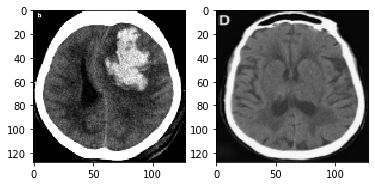

In [6]:
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(images[101])

Slike su solidnog kvaliteta, kao sto je gore diskutovno

# Podela na trening, validation i test set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

C:\Users\ASUS\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Image augmentation

Mogucnost neuralne mreze da nauci razliku izmedju slika sa i bez krvarenja povecava se ako imamo veci skup podataka nad kojim ona uci. Skup od 200 slika nije toliko veliki, tako da se pribegava augmentaciji podataka. 

Jedan od dobrih alata za augmentaciju je keras-ov ImageDataGenerator. U njemu je moguce specificirati koje sve promene se zele izvrsiti. 
U ovom slucaju slike su rotirane, translirane levo-decno i gore-dole i zumirane. 

Na ovaj nacin omoguceno je vestacko prosirivanje dataset-a.

In [10]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

Na sledecoj slici se mogu videti slike nakon augmentacije:

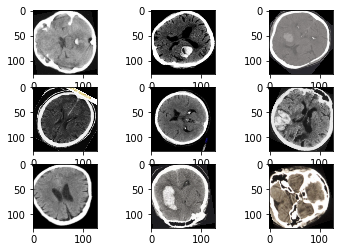

In [11]:
plt.figure()
for X_batch, y_batch in train_image_data.flow(images, labels, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

# Kreiranje modela

In [12]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i], cmap = "gray")
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [13]:
def simple_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [14]:
model = simple_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

# Training model

In [35]:
batch_size = 32
epochs = 50

model.fit_generator(train_image_data.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=16,
    validation_data=validation_image_data.flow(X_val, y_val, batch_size=16),
    validation_steps=math.ceil(len(X_val)/batch_size),
    callbacks=[ModelCheckpoint("weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=epochs)

Epoch 1/50
16/16 [==============================] - 4s 225ms/step - loss: 0.3547 - acc: 0.8780 - val_loss: 0.3992 - val_acc: 0.8750
Epoch 2/50
16/16 [==============================] - 3s 205ms/step - loss: 0.3296 - acc: 0.8795 - val_loss: 0.1743 - val_acc: 1.0000
Epoch 3/50
16/16 [==============================] - 3s 209ms/step - loss: 0.2852 - acc: 0.9130 - val_loss: 0.3859 - val_acc: 0.8750
Epoch 4/50
16/16 [==============================] - 4s 220ms/step - loss: 0.3450 - acc: 0.8642 - val_loss: 0.0310 - val_acc: 1.0000
Epoch 5/50
16/16 [==============================] - 3s 208ms/step - loss: 0.2696 - acc: 0.9130 - val_loss: 0.3493 - val_acc: 0.8125
Epoch 6/50
16/16 [==============================] - 3s 205ms/step - loss: 0.2696 - acc: 0.9150 - val_loss: 0.5264 - val_acc: 1.0000
Epoch 7/50
16/16 [==============================] - 3s 213ms/step - loss: 0.2641 - acc: 0.9035 - val_loss: 0.4248 - val_acc: 0.8750
Epoch 8/50
16/16 [==============================] - 4s 223ms/step - loss: 0.

True positive: 4 , True negative: 13 , False positive: 1 , False negative: 0
Total accuracy: 94.44444444444444 %


(13, 1, 0, 4)

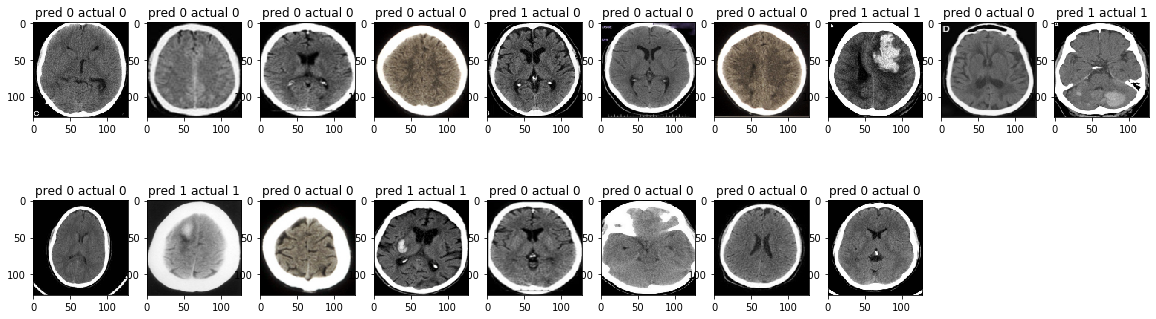

In [36]:
check_accuracy(model, X_val/255., y_val)

In [ ]:
model.save("last-weights.h5")
model.load_weights("weights.h5")

In [37]:
check_accuracy(model, X_train/255., y_train, False)

True positive: 80 , True negative: 65 , False positive: 10 , False negative: 7
Total accuracy: 89.50617283950618 %


(65, 10, 7, 80)

True positive: 8 , True negative: 9 , False positive: 2 , False negative: 1
Total accuracy: 85.0 %


(9, 2, 1, 8)

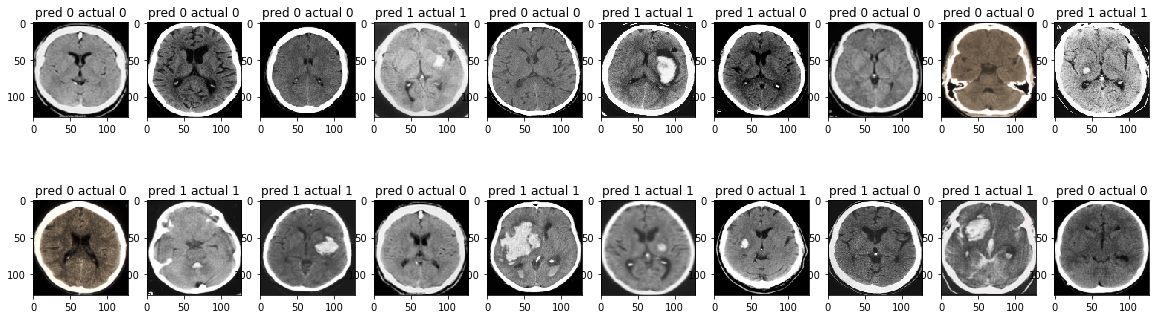

In [38]:
check_accuracy(model, X_test/255., y_test)

# Arhitektura koja izbegava lazno negativne rezultate


S obzirom na vrstu problema, pozeljno da nema lazno negativnih rezultata, jer to moze biti pogubno za pacijenta.

Jedan od nacina da se model "prevari" je da se doda vise slika s pozitivnim rezultatima. Na taj nacin ce model cesce vrsiti predikciju lazno pozitivnih u odnosu na lazno negativne. Jedan nacin da se ovo uradi je da se multipliciraju slike sa krvarenjem. Drugi nacin je da se koristi multiclass klasifikacija u keras-u i da se parametar koristi class_weights, koji u sustini radi istu stvar. 

In [39]:
def imbalance_set(trainX, trainY, coeff=2):
    imbalanced_trainX = []
    imbalanced_trainY = []
    for i, train_x in enumerate(trainX):
        imbalanced_trainX.append(train_x)
        imbalanced_trainY.append(trainY[i])

        if trainY[i] == 1:
            for j in range(coeff-1):
                imbalanced_trainX.append(train_x)
                imbalanced_trainY.append(trainY[i])
    return np.array(imbalanced_trainX), np.array(imbalanced_trainY)

X_train_imbalanced, y_train_imbalanced = imbalance_set(X_train, y_train)
print(X_train_imbalanced.shape, y_train_imbalanced.shape)

(249, 128, 128, 3) (249,)


In [40]:
def bigger_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [41]:
model = bigger_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
__________

In [46]:
model.fit_generator(train_image_data.flow(X_train, y_train, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(X_val, y_val, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("bigger_model_checkpoint_weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=24)

Epoch 1/24
128/128 [==============================] - 82s 639ms/step - loss: 0.2659 - acc: 0.8933 - val_loss: 0.4099 - val_acc: 0.8444
Epoch 2/24
128/128 [==============================] - 78s 608ms/step - loss: 0.2570 - acc: 0.9008 - val_loss: 0.3474 - val_acc: 0.8867
Epoch 3/24
128/128 [==============================] - 79s 618ms/step - loss: 0.2763 - acc: 0.8979 - val_loss: 0.3594 - val_acc: 0.8933
Epoch 4/24
128/128 [==============================] - 81s 629ms/step - loss: 0.2315 - acc: 0.9102 - val_loss: 0.3818 - val_acc: 0.8933
Epoch 5/24
128/128 [==============================] - 76s 597ms/step - loss: 0.2106 - acc: 0.9193 - val_loss: 0.3764 - val_acc: 0.9011
Epoch 6/24
128/128 [==============================] - 80s 628ms/step - loss: 0.2101 - acc: 0.9200 - val_loss: 0.3961 - val_acc: 0.8867
Epoch 7/24
128/128 [==============================] - 79s 615ms/step - loss: 0.1932 - acc: 0.9268 - val_loss: 0.4464 - val_acc: 0.7989
Epoch 8/24
128/128 [==============================] - 7

In [47]:
check_accuracy(model, X_train/255., y_train, False)

True positive: 86 , True negative: 68 , False positive: 7 , False negative: 1
Total accuracy: 95.06172839506173 %


(68, 7, 1, 86)

In [48]:
check_accuracy(model, X_val/255., y_val, False)

True positive: 4 , True negative: 13 , False positive: 1 , False negative: 0
Total accuracy: 94.44444444444444 %


(13, 1, 0, 4)

In [138]:
model.save("bigger_model_latest_weights.h5")
model.load_weights("bigger_model_checkpoint_weights.h5")

True positive: 9 , True negative: 9 , False positive: 2 , False negative: 0
Total accuracy: 90.0 %


(9, 2, 0, 9)

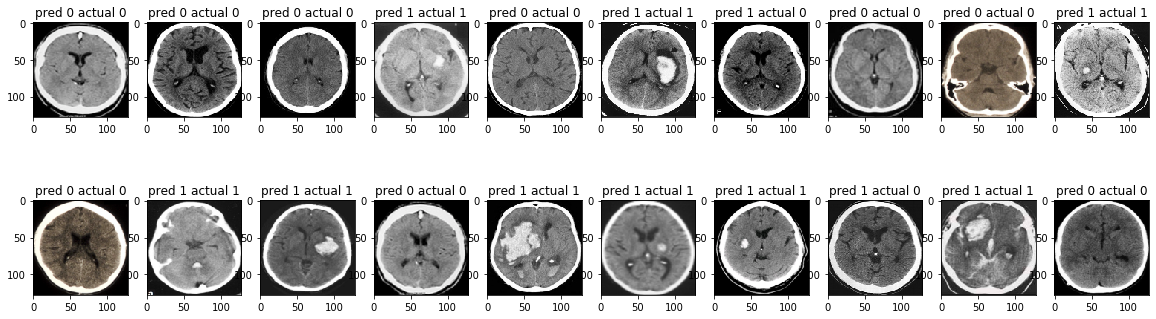

In [49]:
check_accuracy(model, X_test/255., y_test)